# Scikit-learn Beginner's Template

---

## Selected Machine Learning References


### Scikit-learn

* Documentation: http://scikit-learn.org/stable/documentation.html
* User guide: http://scikit-learn.org/stable/user_guide.html

### ML and Python

* Python Data Science Handbook, Jake VanderPlas: https://github.com/jakevdp/PythonDataScienceHandbook

### ML in general

* List of HEP-ML resources: https://github.com/iml-wg/HEP-ML-Resources
* Stanford lecture series on Machine Learning by Andrej Karpathy: https://www.youtube.com/playlist?list=PLkt2uSq6rBVctENoVBg1TpCC7OQi31AlC

---

## Example Analysis

### Preparatory Steps

In [1]:
import math
import itertools

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import pandas as pd
from pandas.tools.plotting import scatter_matrix, radviz

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

### Data Import

Use the Higgs data set from https://archive.ics.uci.edu/ml/datasets/HIGGS.

Data description (taken from the website):

_"The data has been produced using Monte Carlo simulations. The first 21 features (columns 2-22) are kinematic properties measured by the particle detectors in the accelerator. The last seven features are functions of the first 21 features; these are high-level features derived by physicists to help discriminate between the two classes. There is an interest in using deep learning methods to obviate the need for physicists to manually develop such features. Benchmark results using Bayesian Decision Trees from a standard physics package and 5-layer neural networks are presented in the original paper. The last 500,000 examples are used as a test set."_

In [3]:
attributes = [
    'class_label', # 1 for signal, 0 for background
    ##########################################################
    'lepton1_pT', # vvv  low-level features (columns 1-22)  vvv
    'lepton1_eta',
    'lepton1_phi',
    'missing_energy_mag',
    'missing_energy_phi',
    'jet1_pT',
    'jet1_eta',
    'jet1_phi',
    'jet1_btag',
    'jet2_pT',
    'jet2_eta',
    'jet2_phi',
    'jet2_btag',
    'jet3_pT',
    'jet3_eta',
    'jet3_phi',
    'jet3_btag',
    'jet4_pT',
    'jet4_eta',
    'jet4_phi',
    'jet4_btag', # ^^^  low-level features  ^^^
    ########################################################
    'm_jj', # vvv  high-level features (columns 22--28)  vvv
    'm_jjj',
    'm_lv',
    'm_jlv',
    'm_bb',
    'm_wbb',
    'm_wwbb' # ^^^  high-level features  ^^^
]

data = pd.read_csv('./data/higgs/HIGGS.csv',
                   header=None,
                   sep=',',
                   names=attributes,
                   usecols=[0,22,23,24,25,26,27,28],
                   nrows=200000)

X = data.drop(['class_label'], axis=1)
y = (data['class_label']).astype(int)

In [4]:
print('Dimensions of feature matrix X: ', X.shape)
print('Dimensions of target vector y:  ', y.shape)

print('\nTotal number of events in data sample: %d' % X.shape[0])
print('Number of signal events in data sample: %d (%.2f percent)' % (y[y==1].shape[0], y[y==1].shape[0]*100/y.shape[0]))
print('Number of backgr events in data sample: %d (%.2f percent)' % (y[y==0].shape[0], y[y==0].shape[0]*100/y.shape[0]))

Dimensions of feature matrix X:  (200000, 7)
Dimensions of target vector y:   (200000,)

Total number of events in data sample: 200000
Number of signal events in data sample: 105676 (52.84 percent)
Number of backgr events in data sample: 94324 (47.16 percent)


---

### Data Visualization

#### Histograms of the variables

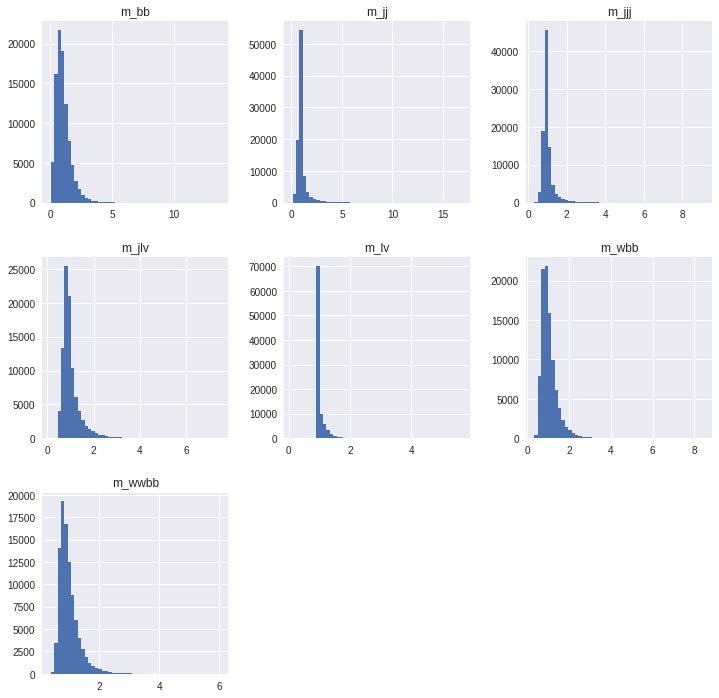

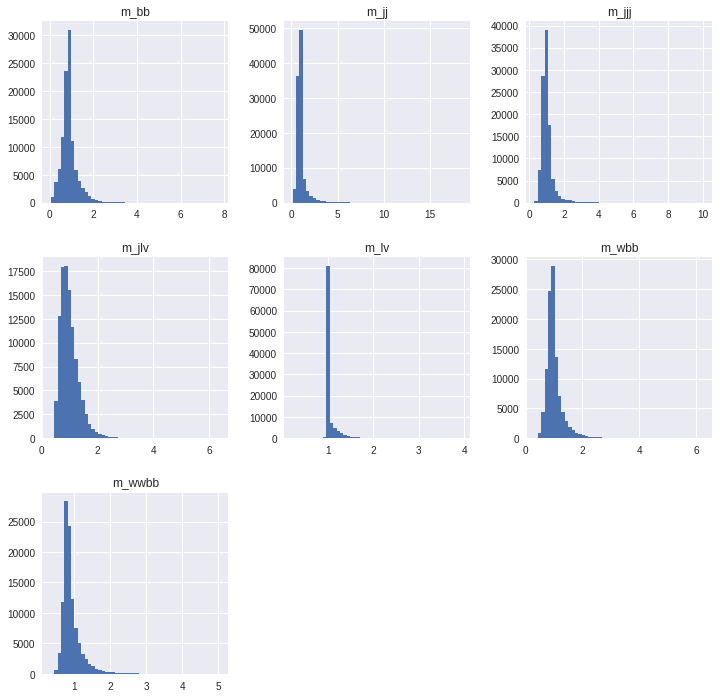

In [5]:
# create one plot for background class and one for signal class

data.groupby('class_label').hist(bins=50, figsize=(12,12))
plt.show()

#### Scatter matrix

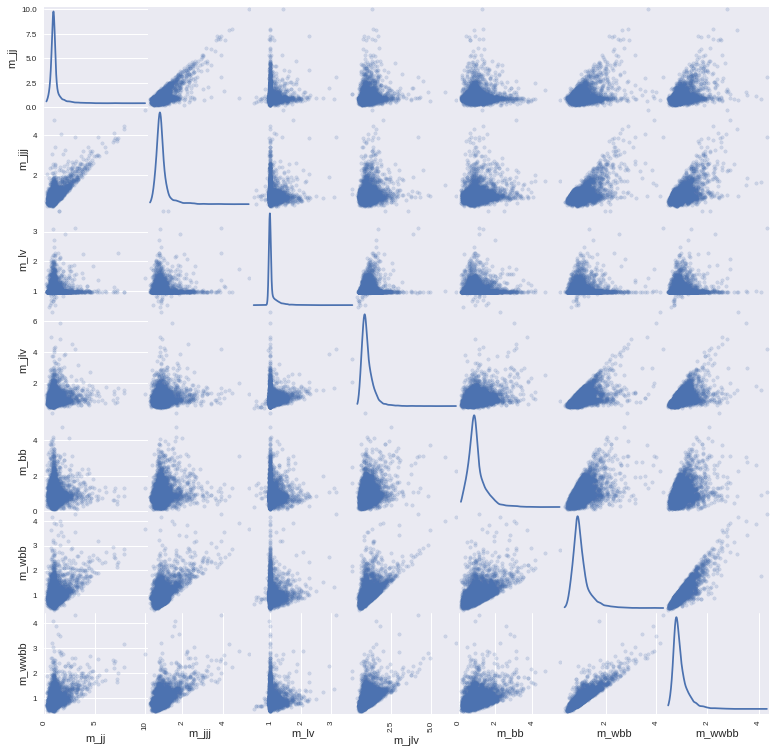

In [6]:
scatter_matrix(data.ix[0:5000,1:28], figsize=(13,13), diagonal='kde', alpha=.2)
plt.show()

#### Correlation Matrix

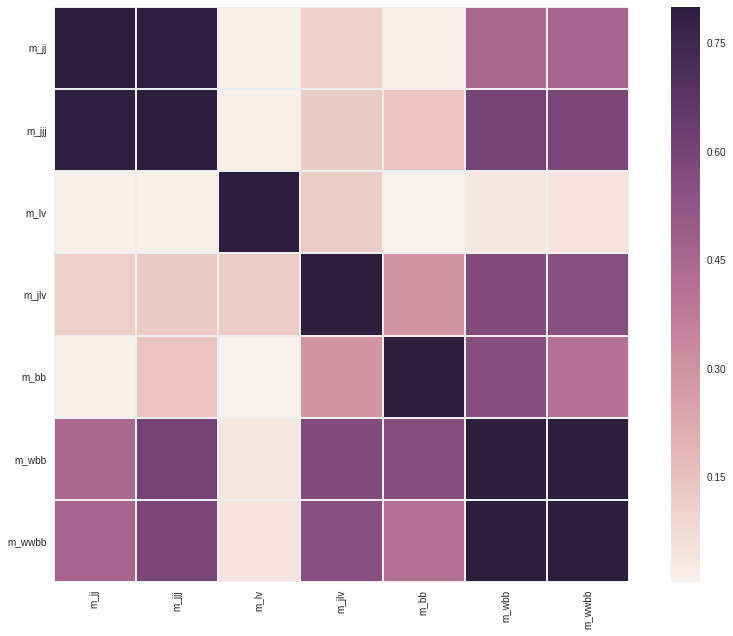

In [7]:
plt.figure()
plt.subplots(figsize=(12,9))
sns.heatmap(X.corr(), vmax=.8, square=True, linewidths=1, linecolor='#eeeeee')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout();

#### RadViz

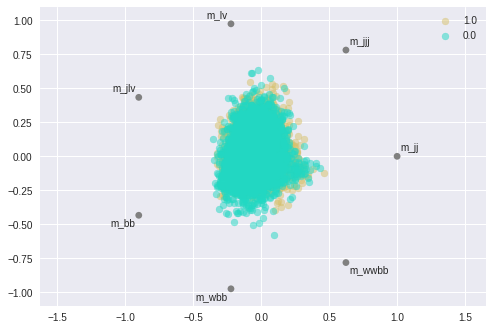

In [8]:
radviz(data.ix[0:10000,:], 'class_label', alpha=.5)

---

### Data Preprocessing

In [9]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

print('Mean values of transformed data: \n', scaler.mean_)
print('Variance of transformed data: \n', scaler.var_)
print('Scale of transformed data: \n', scaler.scale_)

Mean values of transformed data: 
 [ 1.03506297  1.02448363  1.0503859   1.01067494  0.97273317  1.03312208
  0.95992638]
Variance of transformed data: 
 [ 0.43894155  0.14108671  0.02710031  0.15858319  0.27414412  0.13247674
  0.0977675 ]
Scale of transformed data: 
 [ 0.66252664  0.37561511  0.1646217   0.39822505  0.52358774  0.36397354
  0.31267794]


### Data Split Into Training, Validation and Test Sample

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.2,
                                                  random_state=43)

print('Number of training samples:   %d' % X_train.shape[0])
print('Number of validation samples: %d' % X_val.shape[0])
print('Number of test samples:       %d' % X_test.shape[0])

Number of training samples:   160000
Number of validation samples: 40000
Number of test samples:       40000


### Model Definition

In [11]:
clf = RandomForestClassifier(n_estimators=500,
                             criterion='gini',
                             max_depth=None,
                             min_samples_split=500,
                             min_samples_leaf=1,
                             min_weight_fraction_leaf=0.0,
                             max_features=None,
                             max_leaf_nodes=None,
                             min_impurity_split=1e-07,
                             bootstrap=True,
                             oob_score=False,
                             n_jobs=-1,
                             random_state=None,
                             verbose=0,
                             warm_start=False,
                             class_weight=None)

### Model Training

In [12]:
clf = clf.fit(X_train, y_train)

print("Accuracy on training set:   {:.3f}".format(clf.score(X_train, y_train)))
print("Accuracy on validation set: {:.3f}".format(clf.score(X_val, y_val)))

Accuracy on training set:   0.716
Accuracy on validation set: 0.694


Feature ranking:
	1. m_jlv 	(0.397031)
	2. m_wbb 	(0.174330)
	3. m_bb 	(0.136141)
	4. m_lv 	(0.118394)
	5. m_jj 	(0.108104)
	6. class_label 	(0.048353)
	7. m_jjj 	(0.017646)


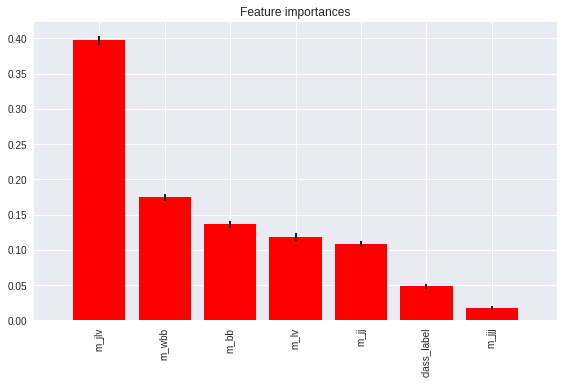

In [13]:
# feature importances

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
    
# Print the feature ranking
print("Feature ranking:")
    
indices_featureNames = np.empty([X_train.shape[1]], dtype=object)
    
for f in range(X_train.shape[1]):
    indices_featureNames[f] = data.columns[indices[f]]
    print("\t%d. %s \t(%f)" % (f + 1,
                               indices_featureNames[f],
                               importances[indices[f]]))
    
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]),
        importances[indices],
        color="r",
        yerr=std[indices],
        align="center")
plt.xticks(range(X_train.shape[1]), indices_featureNames, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()

---

### Model Evaluation on the Validation Sample

In [14]:
# definition of some general plotting parameters
nbins = 100

In [15]:
y_val_score = clf.predict_proba(X_val)

#### MVA output distribution

In [16]:
def plot_MVAoutput(y_truth, y_score, nbins=100):
    """
    Plots the MVA output as histogram and returns the underlying
    distributions of the positive and the negative class.
    """
    
    y_score_negClass, y_score_posClass = np.split(y_score,
                                                  2,
                                                  axis=1)
    
    y_score_posClass_truePos = y_score_posClass[np.array(y_truth==1)]
    y_score_posClass_trueNeg = y_score_posClass[np.array(y_truth==0)]
    
    plt.figure()

    n_total, bins_total, patches_total = \
        plt.hist(y_score[:,1],
                 bins=nbins,
                 alpha=.25,
                 color='black',
                 label='MVA output')
    
    n_trueNeg, bins_trueNeg, patches_trueNeg = \
        plt.hist(y_score_posClass_trueNeg,
                 bins=nbins,
                 alpha=0.5,
                 color='#dd0000',
                 label='true negative')
    
    n_truePos, bins_truePos, patches_truePos = \
        plt.hist(y_score_posClass_truePos,
                 bins=nbins,
                 alpha=0.5,
                 color='green',
                 label='true positive')
    
    plt.title('MVA output distribution (positive class)')
    plt.xlim(-0.05, 1.05)
    plt.xlabel('MVA output')
    plt.ylabel('Entries')
    plt.legend()
    
    return n_truePos, n_trueNeg

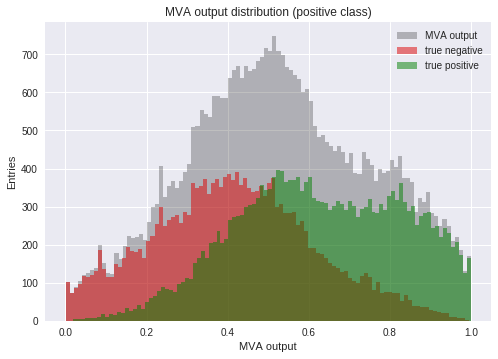

In [17]:
n_truePos, n_trueNeg = plot_MVAoutput(y_val, y_val_score, nbins)

#### Cut efficiencies plot / MVA cut optimization

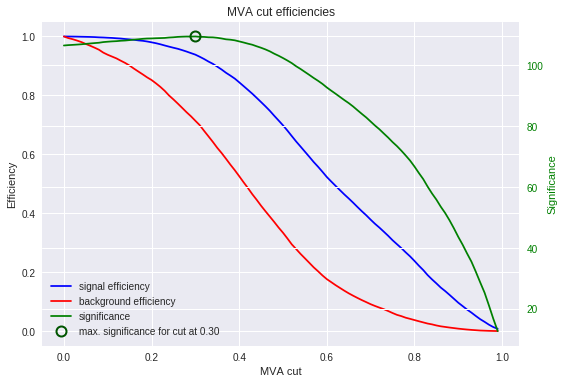

In [18]:
MVAcut = np.empty((0))

plt.figure()
fig, ax1 = plt.subplots()
signal_efficiency = np.empty((0))
backgr_efficiency = np.empty((0))
for i in range(nbins):
    signal_efficiency = np.append(signal_efficiency, \
                                  np.sum(n_truePos[i:n_truePos.shape[0]]) / np.sum(n_truePos))
    backgr_efficiency = np.append(backgr_efficiency, \
                                  np.sum(n_trueNeg[i:n_trueNeg.shape[0]]) / np.sum(n_trueNeg))
    MVAcut = np.append(MVAcut, i/(nbins*1.0))
l1 = ax1.plot(MVAcut, signal_efficiency, label='signal efficiency', color='blue')
l2 = ax1.plot(MVAcut, backgr_efficiency, label='background efficiency', color='red')
ax1.set_xlabel('MVA cut')
ax1.set_ylabel('Efficiency')

ax2 = ax1.twinx()
significance_per_MVAcut = np.empty((0))
for i in range(nbins):
    significance_per_MVAcut = np.append(significance_per_MVAcut, \
                                        np.sum(n_truePos[i:n_truePos.shape[0]]) / \
                                        math.sqrt(np.sum(n_truePos[i:n_truePos.shape[0]] + \
                                                         n_trueNeg[i:n_trueNeg.shape[0]])))
    
l3 = ax2.plot(MVAcut, significance_per_MVAcut,
              label='significance',
              color='green')
pos_max = np.argmax(significance_per_MVAcut)
threshold_pos_max = pos_max/(nbins*1.0)
l4 = ax2.plot(pos_max/(nbins*1.0), significance_per_MVAcut[pos_max],
              label='max. significance for cut at %.2f' % threshold_pos_max,
              marker='o', markersize=10, fillstyle='none', mew=2, linestyle='none',
              color='#005500')
ax2.set_ylabel('Significance', color='green')
ax2.tick_params('y', colors='green')

plt.title('MVA cut efficiencies')
lall = l1+l2+l3+l4
labels = [l.get_label() for l in lall]
ax2.legend(lall, labels, loc='lower left')
plt.tight_layout()

#### ROC curve

In [19]:
def plot_ROCcurve(y_truth, y_score, workingpoint=-1):
    """
    Plots the ROC curve and (if specified) the chosen working point.
    """
    
    fpr, tpr, thresholds = roc_curve(y_truth, y_score[:,1], pos_label=1)
    roc_auc = roc_auc_score(y_truth, y_score[:,1])
    
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    
    if workingpoint != -1:
        # find and plot threshold closest to the chosen working point
        close_threshold_pos_max = np.argmin(np.abs(thresholds-workingpoint))
    
        plt.plot(fpr[close_threshold_pos_max], tpr[close_threshold_pos_max], 'o', markersize=10,
                 label="threshold at %.2f" % workingpoint, fillstyle="none",
                 mew=2)
    
    plt.legend(loc=4)

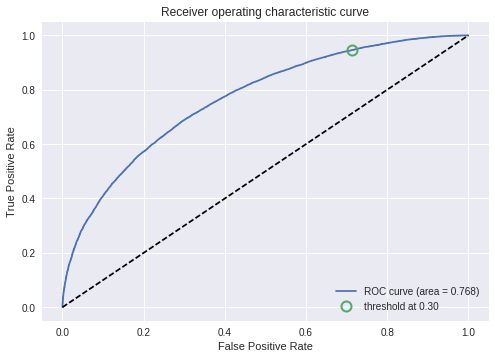

In [20]:
plot_ROCcurve(y_val, y_val_score, threshold_pos_max)

#### Precision-recall curve

In [21]:
def plot_precision_recall_curve(y_truth, y_score, workingpoint=-1):
    """
    Plots the precision-recall curve.
    """
    
    precision = dict()
    recall = dict()
    average_precision = dict()
    
    precision, recall, thresholds_PRC = \
        precision_recall_curve(y_truth,
                               y_score[:,1])
    
    average_precision = average_precision_score(y_truth, y_score[:,1])
    
    # Plot Precision-Recall curve
    n_classes=1
    
    plt.figure()
    plt.plot(recall, precision, lw=2,
             label='Precision-recall curve of signal class (area = {1:0.2f})'
                    ''.format(1, average_precision))
    
    if workingpoint != -1:
        # find threshold closest to the chosen working point
        close_optimum = np.argmin(np.abs(thresholds_PRC-workingpoint))
        
        plt.plot(recall[close_optimum], precision[close_optimum],
                 'o',
                 markersize=10,
                 label="threshold at %.2f" % workingpoint,
                 fillstyle="none",
                 mew=2)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel(r'Recall $R=T_p / (T_p+F_n)$')
    plt.ylabel(r'Precision $P=T_p / (T_p+F_p)$')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower right")

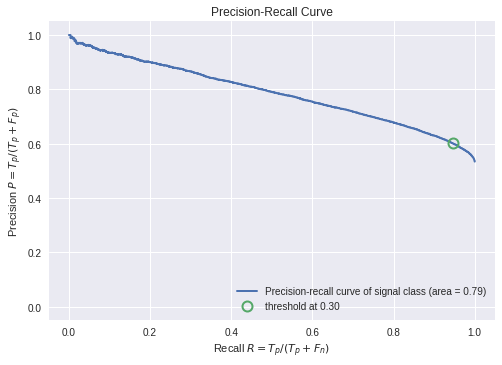

In [22]:
plot_precision_recall_curve(y_val, y_val_score, threshold_pos_max)

#### Confusion matrix

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Plots the confusion matrix. If 'normalize' is set 'True',
    the output matrix will contain percentages instead of
    absolute numbers.
    """
    print('Generating confusion matrix...')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes, rotation=45)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [24]:
# Compute confusion matrix
y_val_score_labels = (y_val_score[:,1] > threshold_pos_max)
cnf_matrix = confusion_matrix(y_val, y_val_score_labels)
np.set_printoptions(precision=2)

Generating confusion matrix...
Confusion matrix, without normalization
[[ 5375 13341]
 [ 1157 20127]]


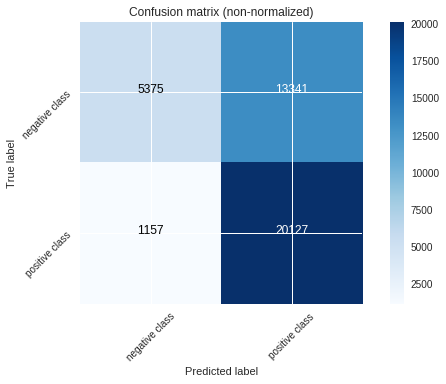

In [25]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=['negative class','positive class'],
                      title='Confusion matrix (non-normalized)')

Generating confusion matrix...
Normalized confusion matrix
[[ 0.29  0.71]
 [ 0.05  0.95]]


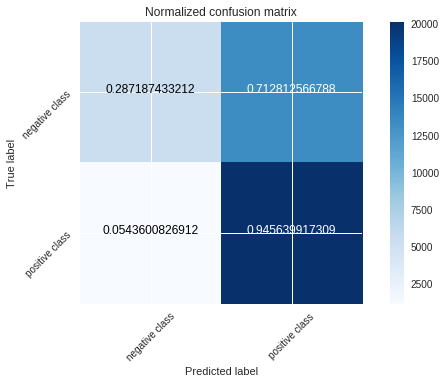

In [26]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=['negative class','positive class'],
                      normalize=True,
                      title='Normalized confusion matrix')

#### Classification report

In [27]:
print(classification_report(y_val, y_val_score_labels,
                            target_names=['negative class','positive class']))

                precision    recall  f1-score   support

negative class       0.82      0.29      0.43     18716
positive class       0.60      0.95      0.74     21284

   avg / total       0.71      0.64      0.59     40000



---

### Model Application to the Test Sample

In [28]:
y_test_score = clf.predict_proba(X_test)

#### MVA output distribution

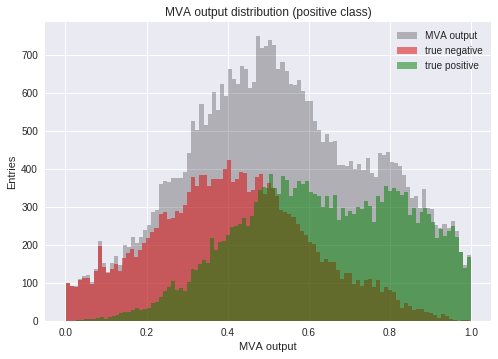

In [29]:
n_truePos, n_trueNeg = plot_MVAoutput(y_test, y_test_score)

#### ROC curve

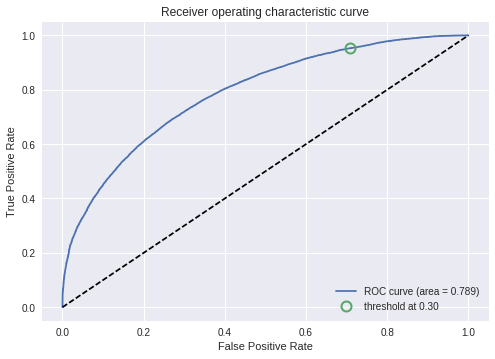

In [30]:
plot_ROCcurve(y_test, y_test_score, threshold_pos_max)

#### Precision-recall curve

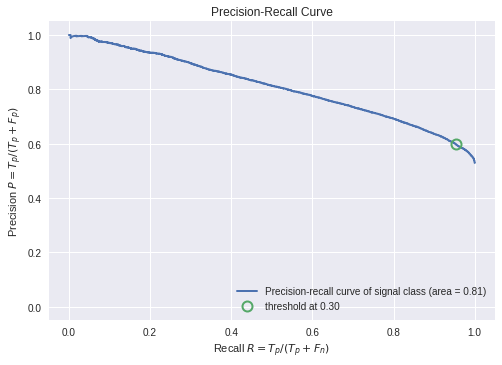

In [31]:
plot_precision_recall_curve(y_test, y_test_score, threshold_pos_max)

#### Confusion matrix

In [32]:
# Compute confusion matrix
y_test_score_labels = (y_test_score[:,1] > threshold_pos_max)
cnf_matrix = confusion_matrix(y_test, y_test_score_labels)
np.set_printoptions(precision=2)

Generating confusion matrix...
Normalized confusion matrix
[[ 0.29  0.71]
 [ 0.05  0.95]]


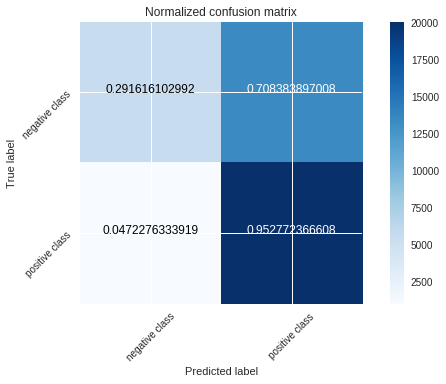

In [33]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=['negative class','positive class'],
                      normalize=True,
                      title='Normalized confusion matrix')

#### Classification report

In [34]:
print(classification_report(y_test, y_test_score_labels,
                            target_names=['negative class','positive class']))

                precision    recall  f1-score   support

negative class       0.85      0.29      0.43     18953
positive class       0.60      0.95      0.74     21047

   avg / total       0.72      0.64      0.59     40000

